In [1]:
%matplotlib inline 
#%load excesses.py

import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt

In [2]:
# bring in the data in csv form
filename = "excess-mortality-raw-death-count-7.csv"
data = pd.read_csv(filename)
#print(data.columns)

# Columns
#--------------------------------------
#Entity - United States
#Code - USA
#Date - 2020-08-30
#"Deaths, 2020, all ages" - 56575
#"Average deaths, 2015–2019, all ages"
#deaths_2015_all_ages - 51735
#deaths_2016_all_ages - 51272
#deaths_2017_all_ages - 51272
#deaths_2018_all_ages - 51272
#deaths_2019_all_ages - 51272


In [3]:
# make sure the dates are formatted properly
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")

# set Country and Date as indexes
data = data.set_index(["Entity", "Date"]).sort_index()

# rename columns for better readability
data.columns = ["Code", "2020", "Average", "2015", "2016", "2017", "2018", "2019"]

In [4]:
# pick which columns to keep
data = data[["Average", "2020", "2019", "2018", "2017", "2016", "2015"]]

In [19]:
# Look at only US data
country = data.loc["United States"]
# drops last row because they added part of the next year to the previous lear with latest data drop
country = country.copy().drop(country.tail(1).index)
print(country)

            Average     2020   2019   2018   2017   2016     2015
Date                                                             
2020-01-05  60340.4  60009.0  58298  66129  59760  55784  61731.0
2020-01-12  60696.4  60700.0  58358  67491  60975  55523  61135.0
2020-01-19  59188.8  59341.0  58217  64641  59286  55178  58622.0
2020-01-26  58318.4  59134.0  57904  62777  58045  55602  57264.0
2020-02-02  57943.0  58799.0  58149  60972  58426  54891  57277.0
2020-02-09  58035.6  59364.0  58519  61107  59036  55103  56413.0
2020-02-16  57673.4  58773.0  57997  59774  58473  55781  56342.0
2020-02-23  56919.4  58853.0  58004  57790  58282  54862  55659.0
2020-03-01  56700.6  59264.0  57968  56690  57250  55871  55724.0
2020-03-08  56893.4  59652.0  58542  57089  57468  56106  55262.0
2020-03-15  55917.6  58622.0  57916  56317  56650  54452  54253.0
2020-03-22  55556.0  59157.0  57092  55758  57041  54660  53229.0
2020-03-29  54831.6  62948.0  56672  54913  55695  53879  52999.0
2020-04-05

In [6]:
# show the sum over the columns
# dropping the last 5 rows due to incomplete data to compare for 2020
print(country.drop(country.tail(4).index).sum(0))

Average    2554819.8
2020       2987996.0
2019       2614761.0
2018       2606682.0
2017       2570498.0
2016       2500084.0
2015       2482074.0
dtype: float64


In [7]:
# show the sum for all rows to compare full year (without all of 2020)
print(country.sum(0))

Average    2779872.6
2020       2987996.0
2019       2845588.0
2018       2831571.0
2017       2804035.0
2016       2725471.0
2015       2692698.0
dtype: float64


In [8]:
# get amount off the average (excess)
country.loc[:,("2020_excess")] = country["2020"] - country["Average"]
country.loc[:,("2019_excess")] = country["2019"] - country["Average"]
country.loc[:,("2018_excess")] = country["2018"] - country["Average"]

# show excess percents
country.loc[:,("2020_excess_percent")] = country["2020_excess"] / country["Average"] * 100

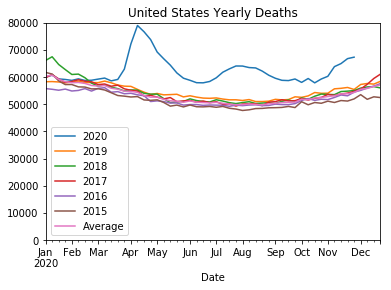

In [9]:
# plot graph of yearly deaths
fig, ax = plt.subplots()
plt.title("United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
country.plot(y=["2020", "2019", "2018", "2017", "2016","2015", "Average"], kind="line", ax=ax, ylim=(0, 80000))
plt.show()

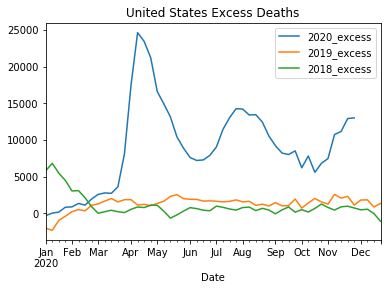

In [10]:
fig, ax = plt.subplots()
plt.title("United States Excess Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter("%m/%d/%Y"))
country.plot(y=["2020_excess", "2019_excess", "2018_excess"], kind="line", ax=ax)
plt.show()

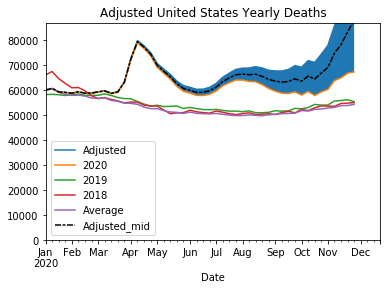

In [17]:
# probabilistic scale factor for possible deaths not yet reported
# https://www.cdc.gov/nchs/data/vsrr/report001.pdf
prob = [
        4.8, 27.2, 43.8, 54.1, 61.9, 67.0, 71.0,
        74.5, 77.4, 79.7, 81.4, 82.8, 83.9, 84.9,
        86.0, 86.9, 88.0, 89.3, 90.3, 91.3, 92.2,
        93.1, 93.8, 94.3, 94.8, 95.2, 95.5, 95.8,
        96.0, 96.2, 96.4, 96.7, 97.1, 97.5, 97.9,
        98.3, 98.6, 98.9, 99.1, 99.3, 99.5, 99.6,
        99.7, 99.8, 99.9, 99.9, 99.9, 100.0, 100.0,
        100.0, 100.0, 100.0
        ]

# Add column for probabilistic death count
adjusted = prob
country["Reported"] = np.array(adjusted[-1:-53:-1])
country["Adjusted"] = (country["2020"].fillna(0) / country["Reported"] * 100.0).fillna(0).astype(int)
country["Adjusted_excess"] = country["Adjusted"] - country["Average"]
country["Adjusted_excess_percent"] = country["Adjusted_excess"] / country["Average"] * 100

country["Adjusted_mid"] = (country["Adjusted"] + country["2020"]) / 2

fig, ax = plt.subplots()
plt.title("Adjusted United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
drop_index = country.tail(4).index
country.drop(drop_index).plot(y=["Adjusted", "2020", "2019", "2018", "Average"], kind="line", ax=ax)
ax.fill_between(country.drop(drop_index).index, country.drop(drop_index)["2020"], country.drop(drop_index)["Adjusted"])
country.plot(y="Adjusted_mid", kind="line", dashes=[4,1,2,1], color="black", ax=ax, ylim=(0, 87000))
plt.show()

In [18]:
print(country[["2020", "2019", "2018", "Average", "Reported"]])

               2020   2019   2018  Average  Reported
Date                                                
2020-01-05  60009.0  58298  66129  60340.4     100.0
2020-01-12  60700.0  58358  67491  60696.4     100.0
2020-01-19  59341.0  58217  64641  59188.8     100.0
2020-01-26  59134.0  57904  62777  58318.4     100.0
2020-02-02  58799.0  58149  60972  57943.0     100.0
2020-02-09  59364.0  58519  61107  58035.6      99.9
2020-02-16  58773.0  57997  59774  57673.4      99.9
2020-02-23  58853.0  58004  57790  56919.4      99.9
2020-03-01  59264.0  57968  56690  56700.6      99.8
2020-03-08  59652.0  58542  57089  56893.4      99.7
2020-03-15  58622.0  57916  56317  55917.6      99.6
2020-03-22  59157.0  57092  55758  55556.0      99.5
2020-03-29  62948.0  56672  54913  54831.6      99.3
2020-04-05  72237.0  56596  55285  54756.6      99.1
2020-04-12  78997.0  55486  55223  54378.0      98.9
2020-04-19  76683.0  54463  54031  53261.6      98.6
2020-04-26  73815.0  53655  53719  52628.0    